In [84]:
from Get_option_data import Get_options_data 
from scipy.optimize import minimize

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_theme(style = 'whitegrid')
plt.style.use('seaborn-whitegrid')


In [86]:
class SABR:
    def __init__(self, Downloaded_options_data: pd.DataFrame) -> None:
        """Class to find and plot volatility smile"""
        self.Options_DataFrame = Downloaded_options_data
        self.years_till_maturity = Downloaded_options_data.days_till_maturity.iloc[0]/365
        
        self.beta = 0.5
        self.first_approximation = np.array([0.99, 0.00, 0.99])
        self.boundaries = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000.0)]


    def _sigma_beta(
        self, underlying_price: float, strike_price: float, alpha: float, rho: float, v: float) -> float:
        """Find model volatility"""
        first_term_of_numerator = ((1 - self.beta) ** 2 / 24 * alpha**2 / (underlying_price * strike_price) ** (1 - self.beta))
        second_term_of_numerator = ((rho * self.beta * v * alpha) / 4 * (underlying_price * strike_price) ** ((1 - self.beta) / 2))
        third_term_of_numerator = (2 - 3 * rho**2) * v**2 / 24

        numerator = alpha * ( 1 + self.years_till_maturity
            * (first_term_of_numerator + second_term_of_numerator + third_term_of_numerator))

        first_term_of_divisor = (1 - self.beta) ** 2 / 24 * (np.log(underlying_price / strike_price)) ** 2
        second_term_of_divisor = (1 - self.beta) ** 4 / 1920 * (np.log(underlying_price / strike_price)) ** 4

        denominator = (underlying_price * strike_price) ** ((1 - self.beta) / 2) * (1 + first_term_of_divisor + second_term_of_divisor)

        zeta = v / alpha * (underlying_price * strike_price) ** ((1 - self.beta) / 2) * np.log(underlying_price / strike_price)

        chi = np.log((np.sqrt(1 - 2 * rho * zeta + zeta**2) + zeta - rho) / (1 - rho))

        return numerator / denominator * zeta / chi

    def _plot(self) -> None:
        """Plot results"""

        def get_volatilities(alpha: float, rho: float, v: float) -> None:
            """Get volatilities for optimization"""
            volatilities = []
            for index, row in self.Options_DataFrame.iterrows():
                sigma_modeled = self._sigma_beta(row.underlying_price, row.strike, alpha, rho, v)
                volatilities.append(sigma_modeled)
            return volatilities

        self.Options_DataFrame["model_volatilities"] = get_volatilities(self.alpha, self.rho, self.v)

        fig, ax = plt.subplots(figsize=(20, 10))
        ax = sns.lineplot(x = "strike", y = "model_volatilities", data = self.Options_DataFrame, label = "model volatilities")
        ax2 = sns.scatterplot(
            x ="strike",
            y ="mark_iv",
            data = self.Options_DataFrame,
            label = "market volatilities",
            color = "black",
        ).set_title("SABR model, days till maturity %.i" %(self.years_till_maturity*365))

    def _find_square_error(self, x: np.ndarray) -> np.float64:
        """Find square error from market and model volatilities"""
        vols = []
        market_volatilities = self.Options_DataFrame.mark_iv.to_numpy()
        for index, row in self.Options_DataFrame.iterrows():
            vols.append(
                self._sigma_beta(
                    row["underlying_price"], row["strike"], x[0], x[1], x[2]))
        return sum((vols - market_volatilities) ** 2)

    def _find_min(self) -> np.float64:
        """Find minimum of square error for market and model data"""
        return minimize(self._find_square_error, x0 = self.first_approximation, bounds = self.boundaries)

    def run(self) -> None:
        """Calculate model volatilities and plot them with volatilities from market"""
        model_min = self._find_min()
        self.alpha, self.rho, self.v = model_min.x
        self._plot()

In [85]:
BTC_DataFrame = Get_options_data("BTC") 

100%|██████████| 326/326 [01:02<00:00,  5.25it/s]


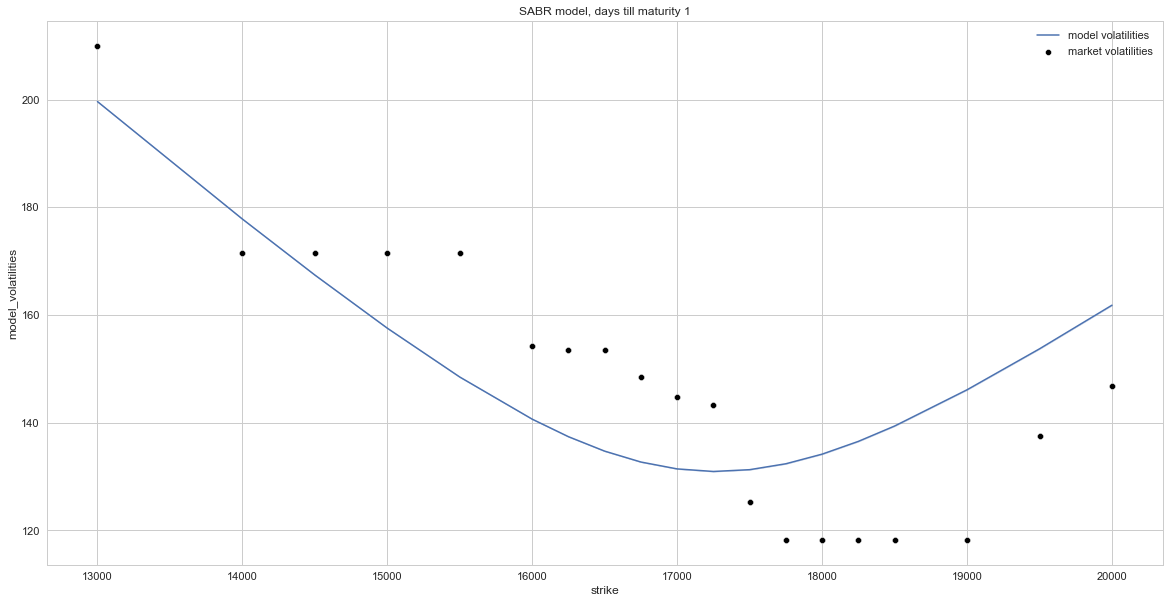

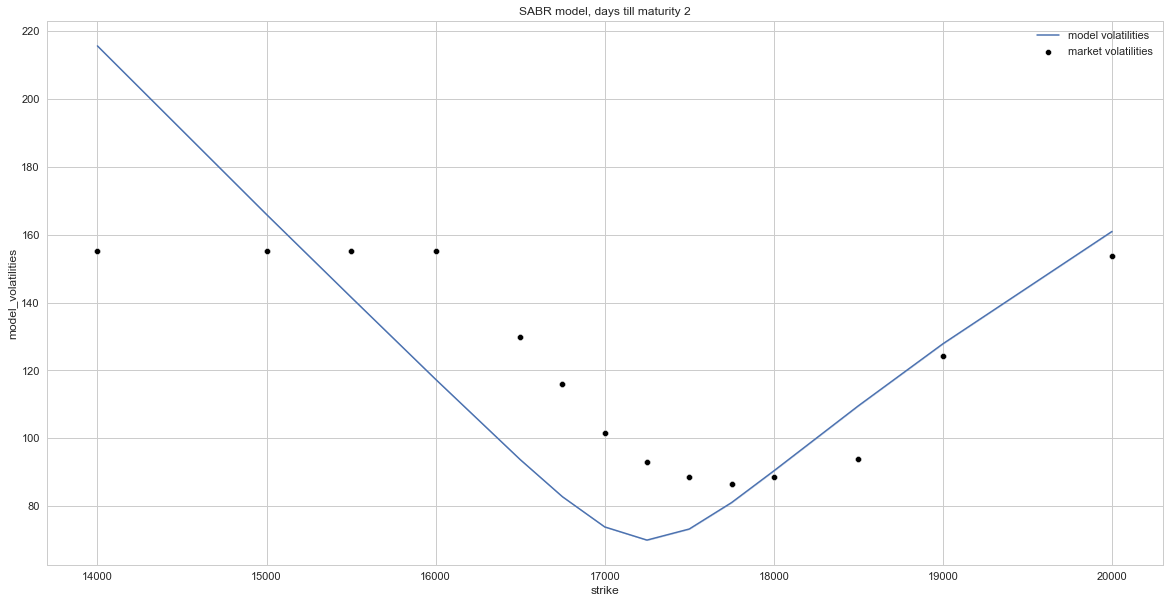

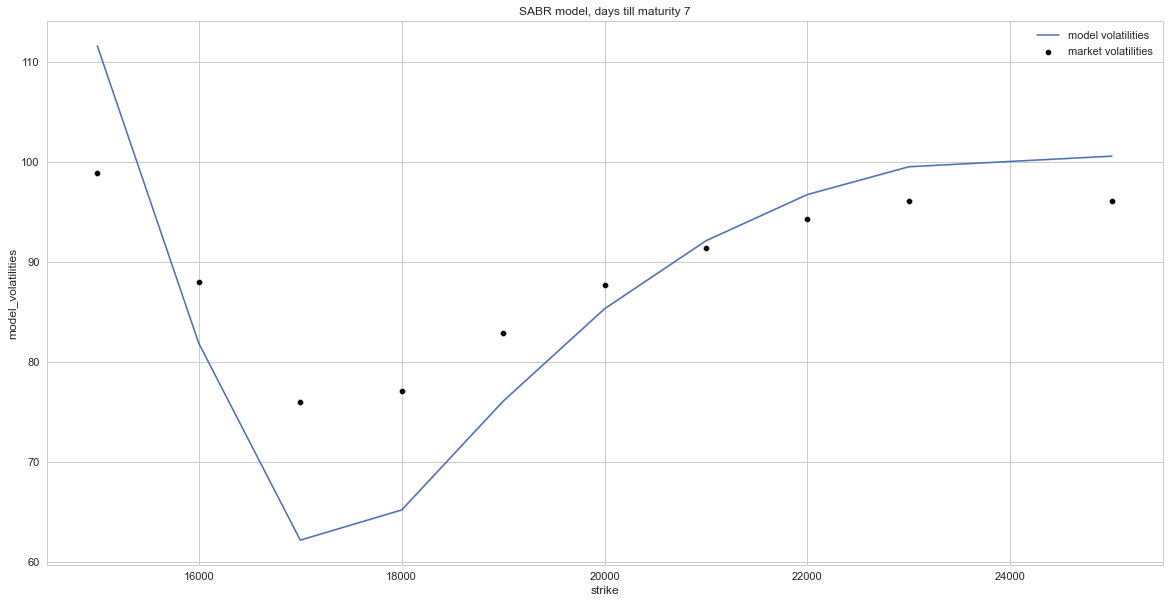

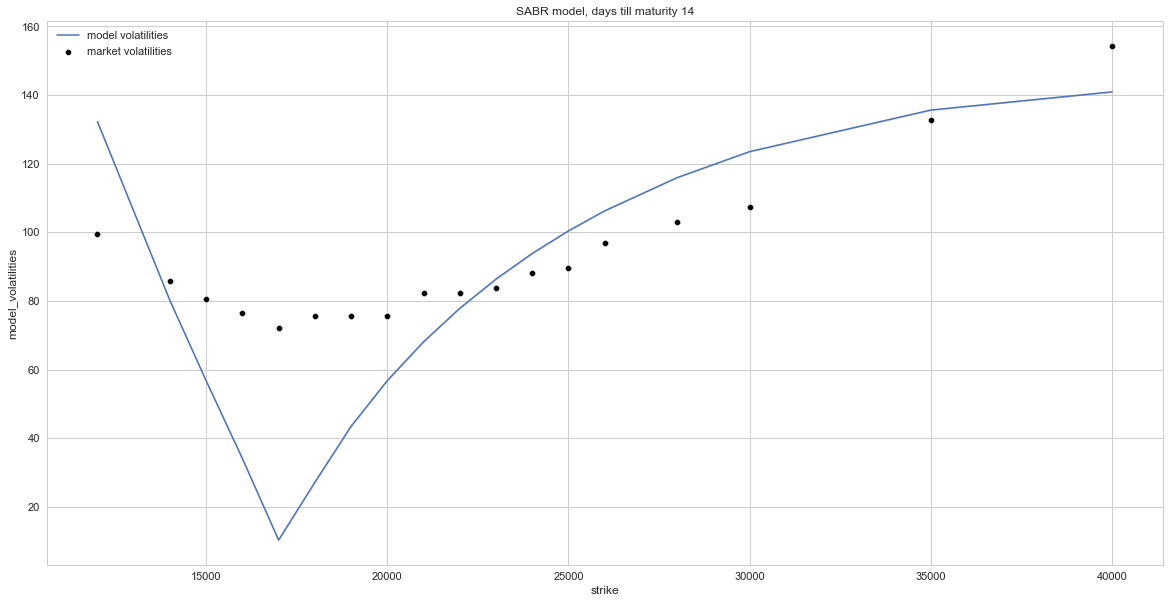

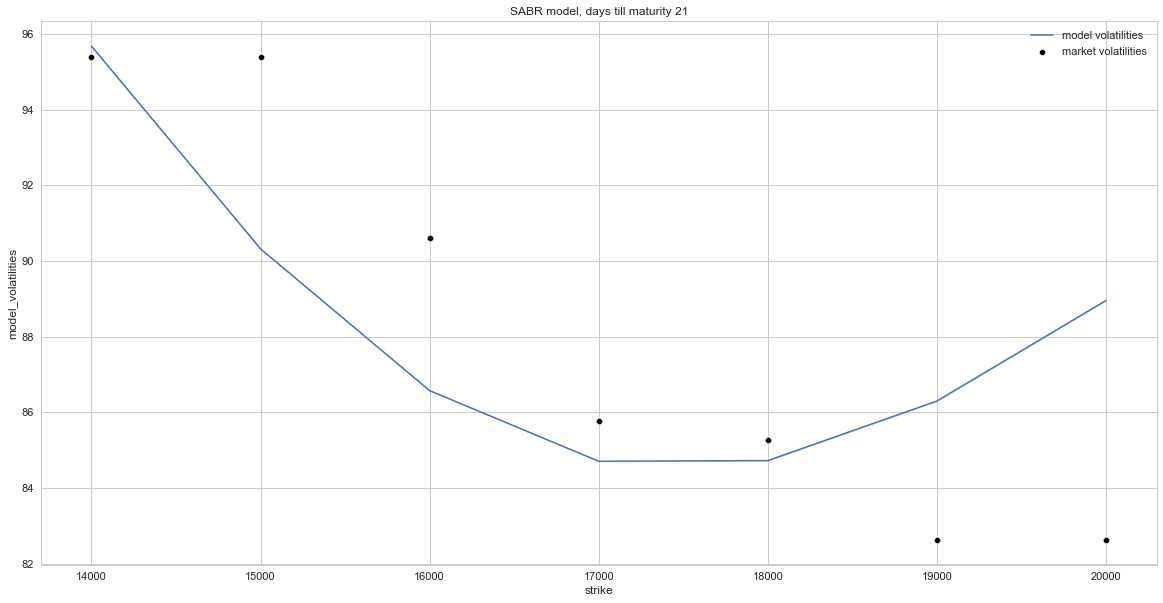

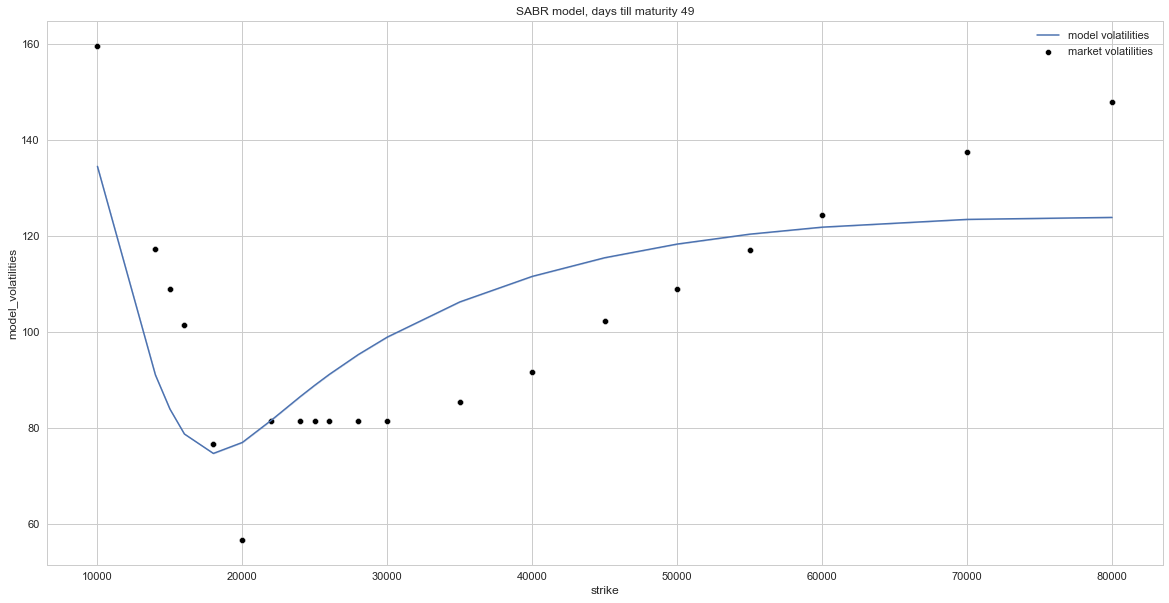

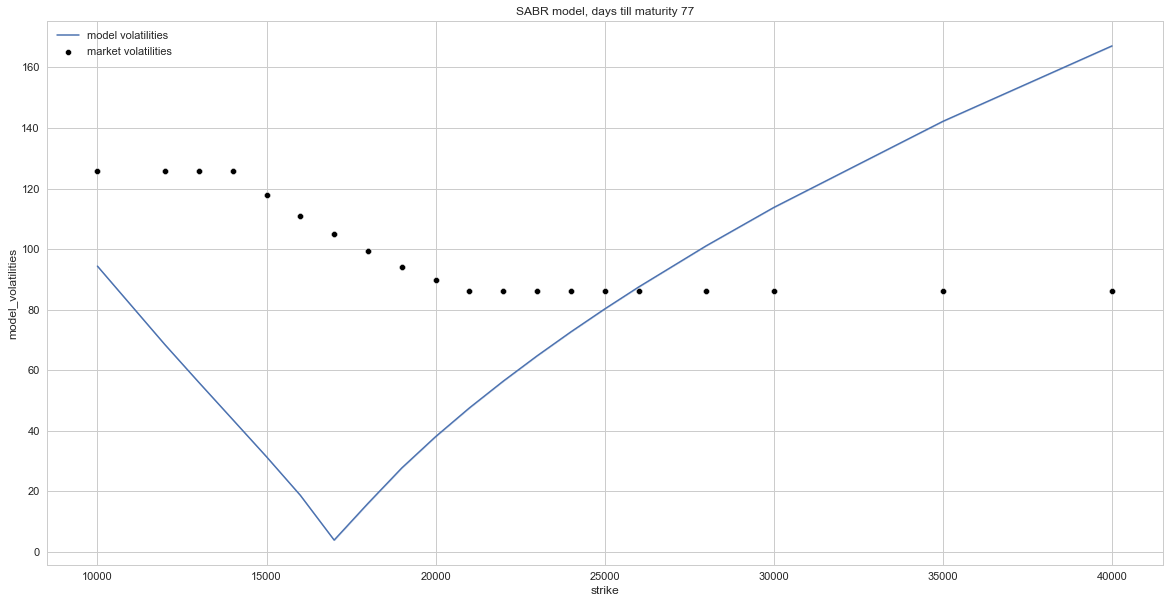

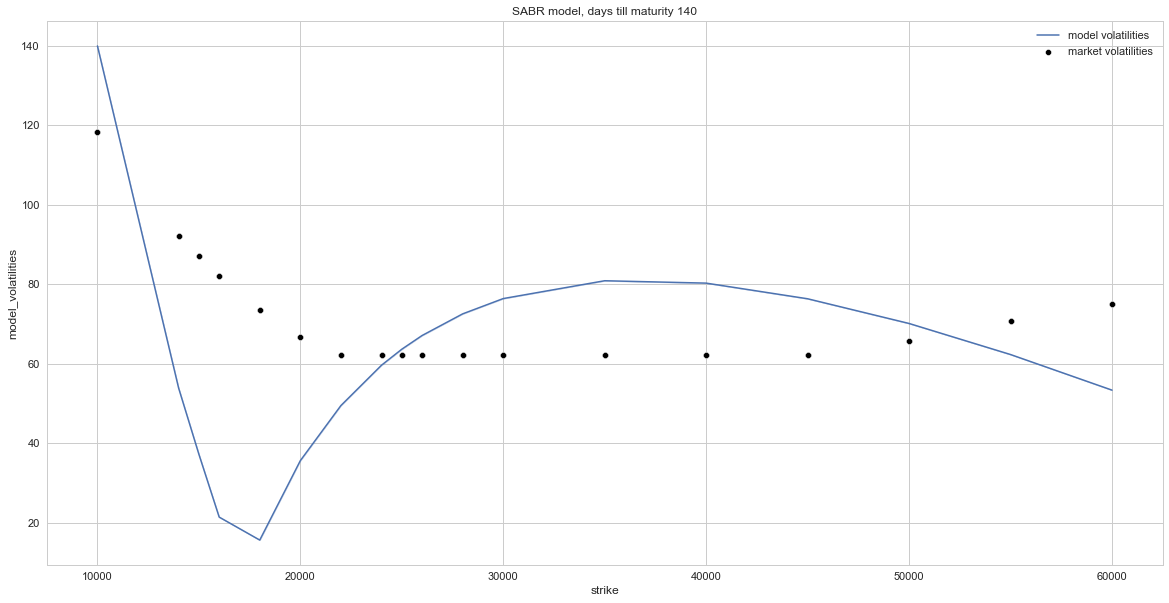

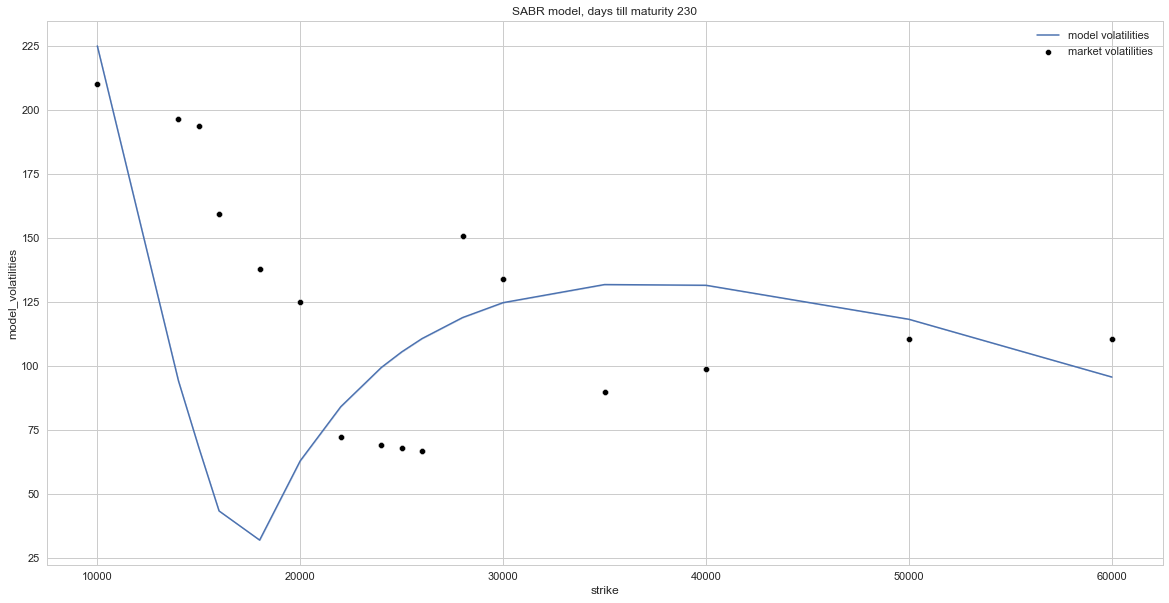

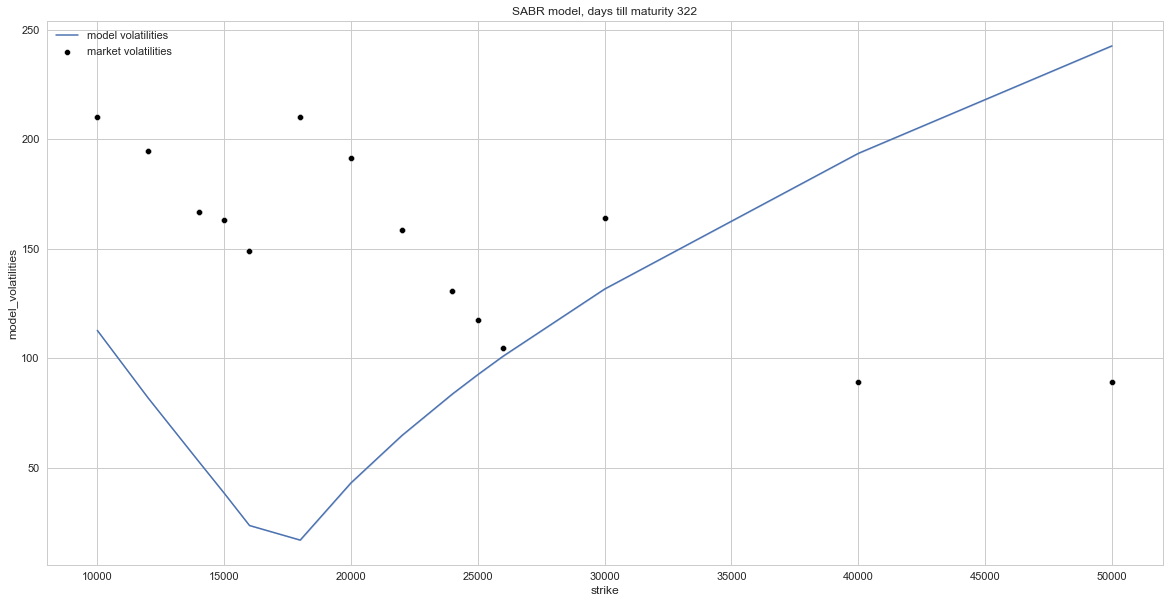

In [90]:
for days in BTC_DataFrame.days_till_maturity.unique():
    BTC_DataFrame_onedate = BTC_DataFrame.loc[BTC_DataFrame['days_till_maturity'] == days]
    sabr = SABR(BTC_DataFrame_onedate[BTC_DataFrame_onedate.strike < 100000])
    #sabr = SABR(BTC_DataFrame_onedate)
    sabr.run()